In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import subprocess
import sys
import time

from astropy.table import Table
from astropy.io import fits

### Handy functions and globals

In [2]:
flux_file = '/home/aalvarez/Work/Data/coupon/fluxes.fits'
nnpz_dir = '/home/aalvarez/Work/Projects/NNPZ'
nnpz_bin = os.path.join(nnpz_dir, 'bin', 'nnpz')
nnpzphoto_bin = os.path.join(nnpz_dir, 'bin', 'NnpzBuildPhotometry')
reference_sample = '/home/aalvarez/Work/Data/dc3/ReferenceSample'
reference_photo = '/home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits'
nnpz_env = os.environ.copy()
nnpz_env['PYTHONPATH'] = nnpz_env.get('PYTHONPATH', '') + ':' + nnpz_dir

output_dir = '/home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft'

In [3]:
nnpz_original_config_file = '/home/aalvarez/Work/Data/coupon/nnpz.conf'
target_catalog = '/home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits'
fluxes_file = '/home/aalvarez/Work/Data/coupon/fluxes.fits'

In [4]:
flux_hdul = fits.open(flux_file)

In [5]:
def extract_filter_set(original_dir, new_dir, filter_name, flux_hdul, hdu_name):
    shutil.rmtree(new_dir, ignore_errors=True)
    shutil.copytree(original_dir, new_dir)
    
    filter_ascii_file = os.path.join(new_dir, filter_name) + '.ascii'
    filter_hdu = flux_hdul[hdu_name]
    t = Table([filter_hdu.data['Wavelength'], filter_hdu.data['Transmission']], names=['col1', 'col2'])
    t.write(filter_ascii_file, format='ascii')

In [6]:
def plot_filter(filter_dir, filter_name):
    content = Table.read(os.path.join(filter_dir, filter_name) + '.ascii', format='ascii')
    plt.plot(content['col1'], content['col2'], label=filter_name)
    plt.legend()

In [7]:
def rebuild_photometry(photometry_output, filters_dir):
    if os.path.exists(photometry_output):
        print(f"{photometry_output} already exists, so skipping run")
        return
        
    nnpzphoto_proc = subprocess.Popen([
        nnpzphoto_bin,
        '--sample-dir', reference_sample,
        '--filters', filters_dir,
        '--out-type', 'F_nu_uJy',
        '--out-file', photometry_output
    ], env=nnpz_env, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    while nnpzphoto_proc.poll() is None:
        print(nnpzphoto_proc.stdout.readline().decode('utf-8'), end='')

In [8]:
def run_nnpz(nnpz_bin, nnpz_config, nnpz_env):
    nnpz_config_file = '/tmp/nnpz_tests/nnpz.conf'
    if os.path.exists(nnpz_config_file):
        os.unlink(nnpz_config_file)

    if os.path.exists(nnpz_config['output_file']):
        print(f"{nnpz_config['output_file']} already exists, so skipping run")
        return 0
        
    with open(nnpz_config_file, mode='w') as fd:
        for key, value in nnpz_config.items():
            if not key.startswith('_'):
                if isinstance(value, str):
                    print(f'{key} = "{value}"', file=fd)
                else:
                    print(f'{key} = {value}', file=fd)

    start = time.monotonic()
    nnpz_proc = subprocess.Popen(
        [nnpz_bin, nnpz_config_file],
        env=nnpz_env, stdout=subprocess.PIPE, stderr=subprocess.STDOUT
    )
    while nnpz_proc.poll() is None:
        print(nnpz_proc.stdout.readline().decode('utf-8'), end='')
    end = time.monotonic()
    return end - start

In [9]:
def plot_matching(reference, target):
    max_count = reference['NeighborIDs'].shape[1]
    counts = np.zeros(max_count + 1) # One position per count (so 0 to as many neighbours in the reference)
    for r, t in zip(reference, target):
        c = np.isin(r['NeighborIDs'], t['NeighborIDs']).sum()
        counts[c] += 1
    plt.hist(range(max_count + 1), weights=counts, bins=max_count+1)
    return counts

## Compare "real" neighbours when using widening

### Recompute photometry

In [10]:
original_filters_dir = '/home/aalvarez/Work/Data/dc3/AuxiliaryData/Filters/Euclid'
filters_dir = '/tmp/nnpz_tests/Wide9Filters'

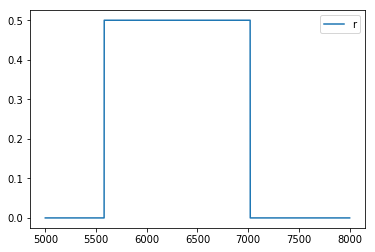

In [11]:
extract_filter_set(original_filters_dir, filters_dir, 'r', flux_hdul, 'r_widening9')
plot_filter(filters_dir, 'r')

In [12]:
r_wide_9_reference_photometry = '/tmp/nnpz_tests/Wide9ReferencePhotometry.fits'
rebuild_photometry(r_wide_9_reference_photometry, filters_dir)

/tmp/nnpz_tests/Wide9ReferencePhotometry.fits already exists, so skipping run


### Find "real" neighbours

In [13]:
real_wide_file = os.path.join(output_dir, 'Wide9Real.fits')

In [14]:
nnpz_config = {}
with open(nnpz_original_config_file) as fd:
    exec(fd.read(), nnpz_config)

In [15]:
nnpz_config['reference_sample_dir'] = reference_sample
nnpz_config['reference_sample_phot_file'] = r_wide_9_reference_photometry
nnpz_config['target_catalog'] = target_catalog
nnpz_config['target_catalog_filters'] = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_widening9_obs', 'r_widening9_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
nnpz_config['target_catalog_filters_mean'] = None
nnpz_config['input_size'] = 2000 # To be changed
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
nnpz_config['output_file'] = real_wide_file
if 'pdz_mc_samples' in nnpz_config:
    del nnpz_config['pdz_mc_samples']

In [16]:
run_nnpz(nnpz_bin, nnpz_config, nnpz_env)

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft/Wide9Real.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Wide9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 2000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_widening9_obs', 'r_widening9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u',

188.35460226295982

### Run now euclidean

In [17]:
nnpz_config['neighbor_method'] = 'KDTree'
nnpz_config['neighbors_no'] = 1000
euclidean_output_file = os.path.join(output_dir, 'Wide9Euclidean.fits')
nnpz_config['output_file'] = euclidean_output_file

In [18]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft/Wide9Euclidean.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Wide9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 1000
    target_catalog_filters_mean : None
    batch_size : 2000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_widening9_obs', 'r_widening9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters 

### Compare euclidean neighbours with "real" neighbours

In [19]:
euclidean = Table.read(euclidean_output_file)
real = Table.read(real_wide_file)

array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         2.00000000e+00,   3.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   4.00000000e+00,   2.00000000e+00,
         8.00000000e+00,   6.00000000e+00,   5.00000000e+00,
         1.00000000e+01,   1.50000000e+01,   1.80000000e+01,
         2.10000000e+01,   4.60000000e+01,   1.11000000e+02,
         1.73600000e+03])

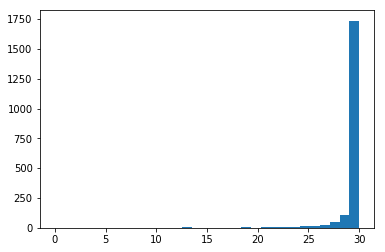

In [20]:
plot_matching(real, euclidean)

### Compare combined neighbours with "real" neighbours
The mean doesn't change, so I don't think it makes sense to 

In [21]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 30
combined_output_file = os.path.join(output_dir, 'Wide9Combined.fits')
nnpz_config['output_file'] = combined_output_file

In [22]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft/Wide9Combined.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Wide9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_widening9_obs', 'r_widening9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : [

In [23]:
combined = Table.read(combined_output_file)

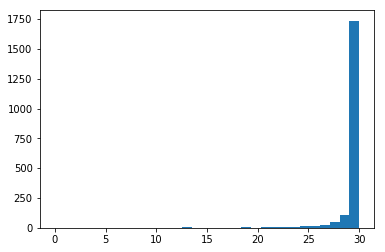

In [24]:
counts = plot_matching(real, combined)

In [25]:
counts[0]

0.0

## Same, but with softening
Let's use `r_softening`.

### Recompute photometry

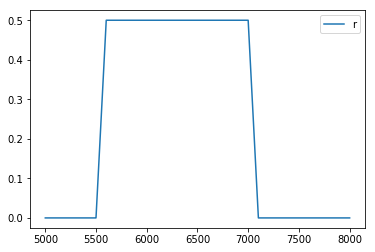

In [26]:
soft9_filters_dir = '/tmp/nnpz_tests/Soft9Filters'
extract_filter_set(original_filters_dir, soft9_filters_dir, 'r', flux_hdul, 'r_softening9')
plot_filter(soft9_filters_dir, 'r')

In [27]:
r_soft_9_reference_photometry = '/tmp/nnpz_tests/Soft9ReferencePhotometry.fits'
rebuild_photometry(r_soft_9_reference_photometry, soft9_filters_dir)

/tmp/nnpz_tests/Soft9ReferencePhotometry.fits already exists, so skipping run


### Get "real" neighbours

In [28]:
nnpz_config['reference_sample_phot_file'] = r_soft_9_reference_photometry
nnpz_config['target_catalog_filters'] = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_softening9_obs', 'r_softening9_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
soft9_output_file = os.path.join(output_dir, 'Soft9Real.fits')
nnpz_config['output_file'] = soft9_output_file

In [29]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft/Soft9Real.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Soft9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_softening9_obs', 'r_softening9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u

### Re-run, KD-Tree, but using the standard reference sample

In [30]:
nnpz_config['reference_sample_phot_file'] = reference_photo
nnpz_config['neighbor_method'] = 'KDTree'
nnpz_config['neighbors_no'] = 1000
soft9_euclidean_output_file = os.path.join(output_dir, 'Soft9Euclidean.fits')
nnpz_config['output_file'] = soft9_euclidean_output_file

In [31]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft/Soft9Euclidean.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 1000
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_softening9_obs', 'r_softening9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filte

In [32]:
soft9_euclidean = Table.read(soft9_euclidean_output_file)

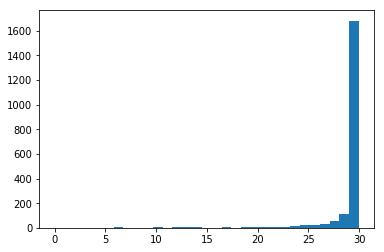

In [33]:
counts = plot_matching(real, soft9_euclidean)

### Softening, Combined

In [34]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 30
soft9_combined_output_file = os.path.join(output_dir, 'Soft9Combined.fits')
nnpz_config['output_file'] = soft9_combined_output_file

In [35]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft/Soft9Combined.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_softening9_obs', 'r_softening9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters 

In [36]:
soft9_combined = Table.read(soft9_combined_output_file)

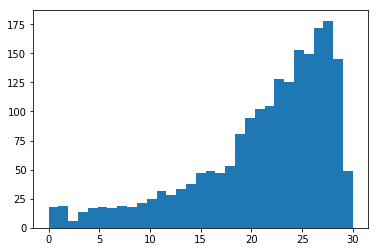

In [37]:
counts = plot_matching(real, soft9_combined)

### Increase more neighbours

In [38]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 50
soft9_50_combined_output_file = os.path.join(output_dir, 'Soft9Combined50.fits')
nnpz_config['output_file'] = soft9_50_combined_output_file

In [39]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_WideSoft/Soft9Combined50.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 50
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_softening9_obs', 'r_softening9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filter

In [40]:
soft9_combined_50 = Table.read(soft9_50_combined_output_file)

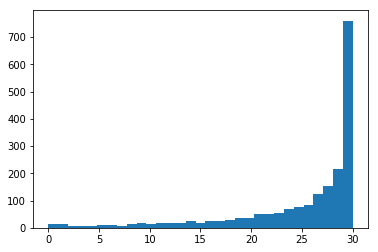

In [41]:
count = plot_matching(real, soft9_combined_50)

Text(0,0.5,'coadded_pdz_50')

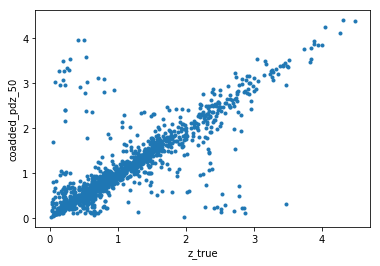

In [57]:
plt.scatter(real['z_true'], real['CoaddedPdz_50'], marker='.')
plt.xlabel('z_true')
plt.ylabel('coadded_pdz_50')

Text(0,0.5,'coadded_pdz_50')

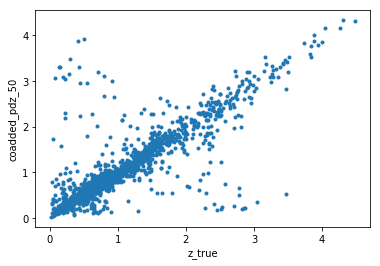

In [59]:
plt.scatter(soft9_combined_50['z_true'], soft9_combined_50['CoaddedPdz_50'], marker='.')
plt.xlabel('z_true')
plt.ylabel('coadded_pdz_50')

In [114]:
def plot_topn(reference, target):
    if not np.all(reference['ID'] == target['ID']):
        raise Exception('ID on reference and target do not match')
    
    max_count = reference['NeighborIDs'].shape[1]
    counts = np.zeros(max_count + 1)
    
    for r, t in zip(reference, target):
        top_index = np.flip(r['NeighborWeights'].argsort(), axis=-1)
        sorted_in = np.isin(r['NeighborIDs'][top_index], t['NeighborIDs'])
        if sorted_in.sum() == max_count:
            counts[max_count] += 1
        else:
            counts[sorted_in.argmin()] += 1
    
    plt.hist(range(max_count + 1), weights=counts, bins=max_count+1)
    return counts

In [107]:
top_index = np.flip(real[0]['NeighborWeights'].argsort(), axis=-1)
print(real[0]['NeighborWeights'][top_index])
print(real[0]['NeighborIDs'][top_index])
np.isin(real[0]['NeighborIDs'][top_index], combined[0]['NeighborIDs']).argmin()

[ 0.14345716  0.11408281  0.0865758   0.07778225  0.0669239   0.06458334
  0.0599095   0.05847847  0.05606081  0.05605197  0.05600841  0.05569724
  0.05545834  0.04965174  0.04909024  0.04901087  0.04889813  0.04879304
  0.04840697  0.04788481  0.04647483  0.04517189  0.04490574  0.04383589
  0.0433402   0.04272079  0.040856    0.04025582  0.03960398  0.03915868]
[709477 479460 697884 781262 779013 246195 942259 394117 821342 776554
 383488 841814 401860 301137 988589 788360 704362 480896 707657 893184
 216439 349690 959823 576712 438018 335331 382087 547820 749596 612969]


0

array([    9.,     7.,     7.,     6.,     4.,     6.,    10.,     3.,
           7.,     4.,     7.,     7.,     9.,     7.,    10.,     9.,
          12.,    10.,     9.,    17.,     6.,    11.,     6.,    13.,
          12.,     7.,     8.,    13.,    13.,    15.,  1736.])

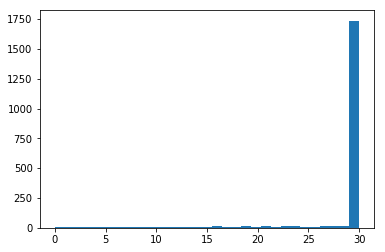

In [115]:
plot_topn(real, combined)

array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         2.00000000e+00,   3.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
         2.00000000e+00,   4.00000000e+00,   2.00000000e+00,
         8.00000000e+00,   6.00000000e+00,   5.00000000e+00,
         1.00000000e+01,   1.50000000e+01,   1.80000000e+01,
         2.10000000e+01,   4.60000000e+01,   1.11000000e+02,
         1.73600000e+03])

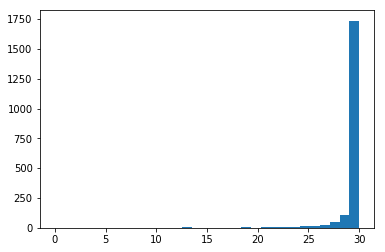

In [116]:
plot_matching(real, combined)